# Active Session 8: Autoencoders

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cihan-ates/data-driven-engineering/blob/master/DDE_I_ML_Dynamical_Systems/Lecture%2010/Lecture_8.ipynb)


# Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





# 1. Problem Definition: Probe into the Data

In this dataset, we will be looking into manufacturing error analysis. The dataset includes modified sensory inputs collected on the manufacturing line and we will be using this multi-dimensional input data to predict the defective products via dimensionality reduction. 

Note that the data set includes over 280,000 instances, where only a small fraction (~500) is defective. 



# 2. Preparing the enviroment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 1.37 ms (started: 2021-01-18 16:03:04 +00:00)


In [2]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import os
import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
#import altair as alt
import plotly.express as px

time: 586 ms (started: 2021-01-18 16:03:04 +00:00)


In [3]:
# Data Preparation
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report


time: 39 ms (started: 2021-01-18 16:03:05 +00:00)


In [4]:
# ML Algorithms to be used
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras import optimizers, models, layers, regularizers
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.losses import mse, binary_crossentropy

time: 1.42 s (started: 2021-01-18 16:03:05 +00:00)


# 3. Pre-processing


## Loading the Data

We need to upload the dataset to Colab enviroment. Pandas library is a practical way to load and read the data from an url. 

The data is on ILIAS so this week you need to upload the data from your local pc / by using Google Drive link. 

In [5]:
# Loading the data

#Local drive:
#from google.colab import files
#uploaded = files.upload()
#data = pd.read_csv('manufacturing.csv')
#data.head()

time: 1.49 ms (started: 2021-01-18 16:03:06 +00:00)


In [6]:
# Loading the data
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

time: 2.22 s (started: 2021-01-18 16:03:06 +00:00)


In [7]:
downloaded = drive.CreateFile({'id':'1mQZTB5gEkal_qH0TiivXAJY082Wclfbo'}) 
downloaded.GetContentFile('manufacturing.csv')
data = pd.read_csv('manufacturing.csv')
data.head()

,Time,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22,S23,S24,S25,S26,S27,S28,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,regular
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,regular
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,regular
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,regular
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,regular


time: 9.51 s (started: 2021-01-18 16:03:08 +00:00)


In [8]:
os.listdir('.')

['.config',
 'my_best_model_AE_2.h5',
 'my_best_model_AE_reLU.h5',
 'manufacturing.csv',
 'my_best_model_AE_int.h5',
 'adc.json',
 'my_best_model_AE.h5',
 'my_best_model_noise.h5',
 'my_best_model_AE_Sparse.h5',
 'my_best_model_AE_Sparse_2.h5',
 'sample_data']

time: 3.48 ms (started: 2021-01-18 16:03:18 +00:00)


## Data Exploration
Here we will look into the statistics of the data, identify any missing values or categorical features that is needed to be further process.

Let’s analyze our dataset first. Use dataset.head(n) to display top n data. You can change dataset.head(n) to dataset.sample(n) to display randomly picked data:

In [9]:
data.sample(5)

,Time,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22,S23,S24,S25,S26,S27,S28,Class
132851,80143.0,-2.635638,2.371788,-1.057976,-1.699740,-0.595885,-0.025297,-0.913476,1.861117,-0.325056,-0.279705,0.060648,1.510778,1.214124,0.987116,-0.170384,1.092751,-0.449232,-0.042240,-0.446635,-0.027137,0.048252,-0.171165,0.092688,-1.103577,0.108182,0.848057,-0.250755,-0.006164,regular
118123,74958.0,-1.060513,0.080976,1.786851,-0.608174,0.611665,-0.794440,0.168083,0.120195,-0.688646,-0.476376,0.944446,0.212724,-0.417530,0.417386,0.363860,0.487197,-0.604884,0.366869,0.674630,0.226622,0.012519,-0.292892,-0.132391,0.032214,0.152155,0.939974,-0.075486,0.053509,regular
132847,80141.0,-1.347806,0.513449,1.066660,-0.049939,-0.124794,0.080693,1.982543,-0.517086,-0.483468,-0.074627,0.921680,0.262428,-0.204474,0.089439,-0.218987,0.487393,-1.191163,0.513584,-0.401848,-0.358240,0.022565,0.364589,-0.327736,0.027687,0.302771,-0.522185,-0.370661,-0.022077,regular
48752,43773.0,1.015943,-0.013354,0.451386,1.366331,-0.265426,0.037422,0.008893,0.126304,0.063913,0.031960,1.285690,1.103885,-0.587659,0.353851,-0.765485,-0.563523,0.107761,-0.497081,-0.167489,-0.111510,-0.012070,0.040270,-0.086849,0.237919,0.576984,-0.346751,0.025135,0.015417,regular
17983,29087.0,1.356317,-0.392223,-0.047452,-0.705066,-0.714307,-1.133734,-0.146046,-0.277269,-1.413455,0.834725,1.672328,0.280287,0.282236,0.228909,-0.319016,0.868641,0.208856,-1.130458,0.809757,0.121413,0.315657,0.797778,-0.193380,0.606906,0.759804,-0.072535,-0.030075,-0.002300,regular


time: 54.6 ms (started: 2021-01-18 16:03:18 +00:00)


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   S1      284807 non-null  float64
 2   S2      284807 non-null  float64
 3   S3      284807 non-null  float64
 4   S4      284807 non-null  float64
 5   S5      284807 non-null  float64
 6   S6      284807 non-null  float64
 7   S7      284807 non-null  float64
 8   S8      284807 non-null  float64
 9   S9      284807 non-null  float64
 10  S10     284807 non-null  float64
 11  S11     284807 non-null  float64
 12  S12     284807 non-null  float64
 13  S13     284807 non-null  float64
 14  S14     284807 non-null  float64
 15  S15     284807 non-null  float64
 16  S16     284807 non-null  float64
 17  S17     284807 non-null  float64
 18  S18     284807 non-null  float64
 19  S19     284807 non-null  float64
 20  S20     284807 non-null  float64
 21  S21     28

##Label Encoding

Unlike the previous airfoil example, here we have an object column for the labels (see Class). Lets convert the NaN data into categorical values. Here you can use either pandas dataframe directly or use scikit learn. For scikit implementation, you may check:

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

For our case, we will directly work on the dataframe and customize the labels as we want:

In [11]:
data["Class"].value_counts()

regular      284315
defective       492
Name: Class, dtype: int64

time: 31.7 ms (started: 2021-01-18 16:03:18 +00:00)


As you can see, we have two categories; `regular` and `defective`. We want to label them in a way that regulars are '0' and defectives are as '1'. In this case, we can use the `str` accessor plus `np.where` to modify the target column:

In [12]:
data["Class"] = np.where(data["Class"].str.contains("reg"), 0, 1)
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

time: 115 ms (started: 2021-01-18 16:03:18 +00:00)


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   S1      284807 non-null  float64
 2   S2      284807 non-null  float64
 3   S3      284807 non-null  float64
 4   S4      284807 non-null  float64
 5   S5      284807 non-null  float64
 6   S6      284807 non-null  float64
 7   S7      284807 non-null  float64
 8   S8      284807 non-null  float64
 9   S9      284807 non-null  float64
 10  S10     284807 non-null  float64
 11  S11     284807 non-null  float64
 12  S12     284807 non-null  float64
 13  S13     284807 non-null  float64
 14  S14     284807 non-null  float64
 15  S15     284807 non-null  float64
 16  S16     284807 non-null  float64
 17  S17     284807 non-null  float64
 18  S18     284807 non-null  float64
 19  S19     284807 non-null  float64
 20  S20     284807 non-null  float64
 21  S21     28

Let's look into the statistics of the data. This is usually a good starting point to have an idea about the range of the data, its nature, as well as the 
missing information for different features:

In [14]:
data.describe()

,Time,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22,S23,S24,S25,S26,S27,S28,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,1.758743e-12,-8.252298e-13,-9.636929e-13,8.316157e-13,1.591952e-13,4.247354e-13,-3.050180e-13,8.693344e-14,-1.179712e-12,7.094854e-13,1.875015e-12,1.053488e-12,7.137527e-13,-1.491363e-13,-5.225914e-13,-2.280712e-13,-6.428517e-13,4.958987e-13,7.060712e-13,1.766038e-12,-3.406543e-13,-5.713163e-13,-9.725303e-13,1.464139e-12,-6.989087e-13,-5.615260e-13,3.332112e-12,-3.518886e-12,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000


time: 381 ms (started: 2021-01-18 16:03:18 +00:00)


If not defined by the user, you can also explore the features with the following command:

In [15]:
data.columns


Index(['Time', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
       'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
       'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'Class'],
      dtype='object')

time: 4.93 ms (started: 2021-01-18 16:03:19 +00:00)


It is also possible to explore individual features:

In [16]:
data['S12'].median()

0.140032588

time: 7.77 ms (started: 2021-01-18 16:03:19 +00:00)


In [17]:
data['S12'].mean()

1.0534877568289322e-12

time: 2.81 ms (started: 2021-01-18 16:03:19 +00:00)


## Identify non-numerical values
Some ML algorithms can not handle non-numerical values (NaN: not a number) so you may need to identify the type of the data for each feature and modify it if necessary. It is also quite common that different feature values are missing for different instances / examples so you may need to decide what to do: (i) omit the instance; (ii) replace them with the mean / median / mode of the feature; (iv) substitute them with a value of your choice.

The following line counts the NaNs for each feature for us. Note that in previous exercises, we used np for the task; not pandas. Since here we have an integer type in the Dataframe, np.isnan does not work here. This function takes a scalar or array-like object and indicates whether values are missing (NaN in numeric arrays, None or NaN in object arrays, NaT in datetimelike).

In [18]:
nanCounter = pd.isnull(data).sum()
print(nanCounter)

Time     0
S1       0
S2       0
S3       0
S4       0
S5       0
S6       0
S7       0
S8       0
S9       0
S10      0
S11      0
S12      0
S13      0
S14      0
S15      0
S16      0
S17      0
S18      0
S19      0
S20      0
S21      0
S22      0
S23      0
S24      0
S25      0
S26      0
S27      0
S28      0
Class    0
dtype: int64
time: 29.6 ms (started: 2021-01-18 16:03:19 +00:00)


It is also a good exercise to check the uniqueness of the dataset, that is, whether there exists values repeating at different instances:

In [19]:
distinctCounter = data.apply(lambda x: len(x.unique()))
print(distinctCounter)

Time     124592
S1       275653
S2       275655
S3       275657
S4       275654
S5       275657
S6       275652
S7       275651
S8       275643
S9       275656
S10      275646
S11      275648
S12      275654
S13      275657
S14      275653
S15      275653
S16      275645
S17      275646
S18      275655
S19      275645
S20      275632
S21      275617
S22      275644
S23      275611
S24      275645
S25      275640
S26      275647
S27      275597
S28      275558
Class         2
dtype: int64
time: 216 ms (started: 2021-01-18 16:03:19 +00:00)


## Data Visualization

Another important pre-processing step is the data visualization. Histograms are suitable for a holistic view, where we can probe into the data for each attribute.

We can use `hist` from matplotlib for that purpose:

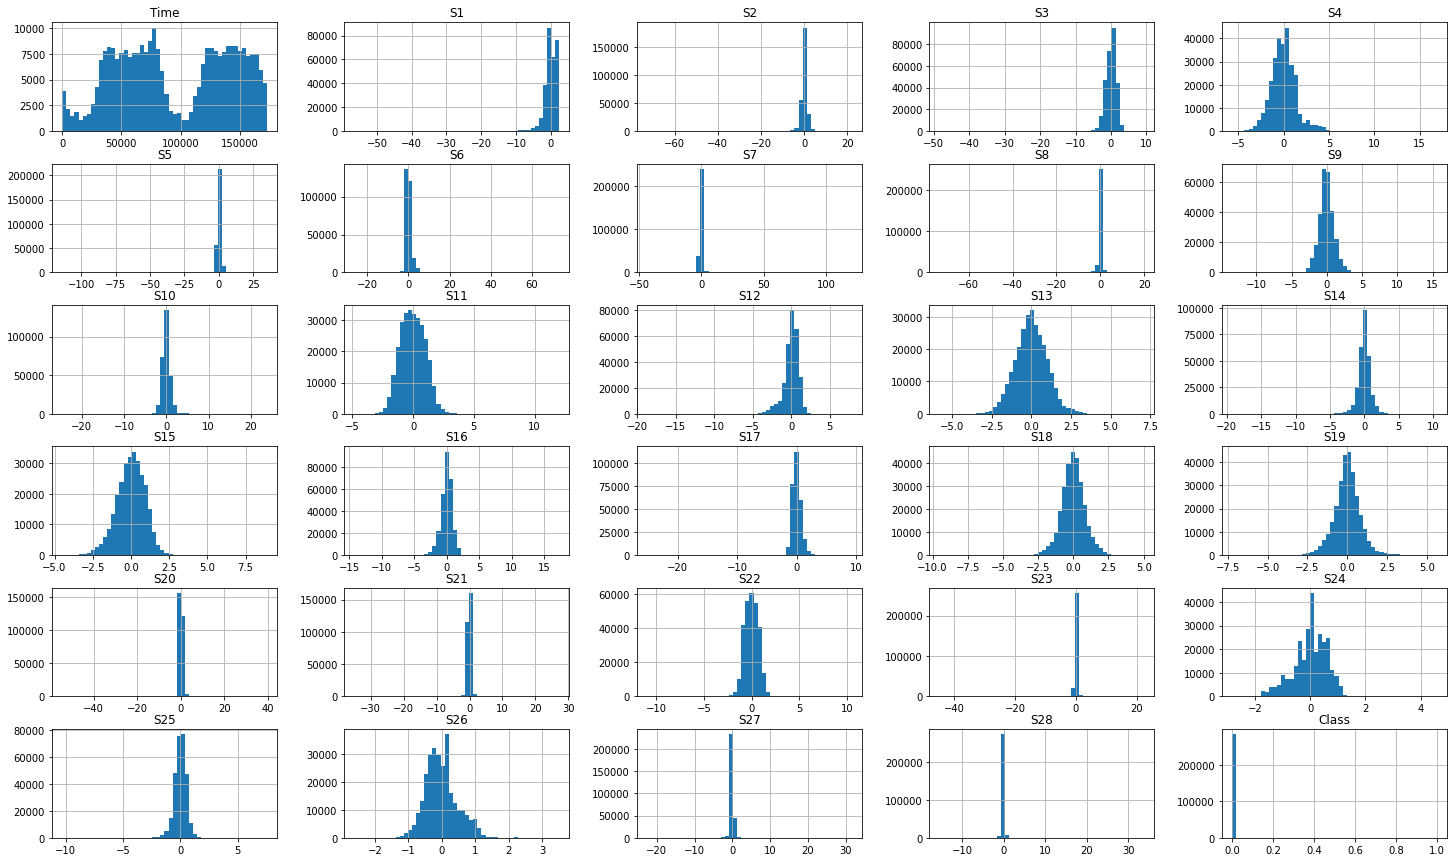

time: 5.3 s (started: 2021-01-18 16:03:19 +00:00)


In [20]:
data.hist(bins=50, figsize=(25,15))
plt.show()

## Creating the Feature Matrix and Labels

In [21]:
#Splitting the data
dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].astype(int).copy()

time: 58.6 ms (started: 2021-01-18 16:03:24 +00:00)


In [22]:
#Checking the labels
dataY.value_counts()

0    284315
1       492
Name: Class, dtype: int64

time: 8.74 ms (started: 2021-01-18 16:03:24 +00:00)


## Feature Standardization: Rescaling the Data

Feature engineering is an inseparable aspect of ML models. In many engineering problem, we know from our tradition that combining different features significantly simplifies the problem and help us to focus our experimental / numerical work on the correct data plane. For example, we combine characteristic length, velocity, density and viscosity as Reynolds number and "classify" the flow regime in a pipe in a quite straight-forward way. The same is true on ML algorithms. You can combine features, delete the unrelated ones and rescale the data (similar to what we do in non-dimensional analysis in engineering) to help ML algorithms to seek patterns from an unbiased perspective. 

For the time being, lets just see how much the features are correlated. But first, we will rescale the data. It is  important to remember that most ML algorithms work better if the data is normalized around zero; that it has a mean value of zero with a standard deviation of one. Let's try it ourselves:

In [23]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,Time,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22,S23,S24,S25,S26,S27,S28
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,-1.050379e-14,-1.536091e-15,-3.693350e-16,-2.082561e-15,9.153351e-16,5.854865e-18,2.784804e-16,2.636489e-16,2.820733e-16,1.465833e-16,9.990241e-17,-6.106607e-16,1.408301e-15,4.043764e-16,1.110118e-16,2.075961e-15,-9.586821e-17,3.840856e-16,3.894075e-16,-4.477913e-17,-5.225632e-16,1.308865e-16,-8.043247e-16,-6.657393e-17,1.487786e-16,-4.774076e-16,-3.018009e-16,3.521028e-17,-4.119621e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.996583e+00,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,-2.258191e+01,-4.700128e+00,-1.869868e+01,-5.819392e+00,-2.004428e+01,-4.915191e+00,-1.612534e+01,-2.962645e+01,-1.133266e+01,-8.861402e+00,-7.069146e+01,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01
25%,-8.552120e-01,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,-4.917360e-01,-7.470224e-01,-4.058964e-01,-6.516198e-01,-4.439565e-01,-6.368132e-01,-5.341353e-01,-5.695609e-01,-5.951621e-01,-5.605369e-01,-2.746334e-01,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01
50%,-2.131453e-01,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,-8.533551e-02,-3.209268e-02,1.401448e-01,-1.363250e-02,5.278702e-02,5.251917e-02,7.579255e-02,-7.732604e-02,-4.338370e-03,4.588014e-03,-8.104705e-02,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02
75%,9.372174e-01,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,4.168842e-01,7.245863e-01,6.187332e-01,6.656518e-01,5.144513e-01,7.088502e-01,5.971989e-01,4.705737e-01,5.974968e-01,5.637928e-01,1.725733e-01,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01
max,1.642058e+00,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,2.180758e+01,1.177504e+01,7.854679e+00,7.160735e+00,1.098147e+01,9.699117e+00,1.976044e+01,1.089502e+01,6.014342e+00,6.869414e+00,5.113464e+01,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02


time: 561 ms (started: 2021-01-18 16:03:24 +00:00)


As you can see, mean value is fixed as zero with a standard deviation (std) of 1. Now let's try to visualize how correlated the data is by creating a correlation matrix. 

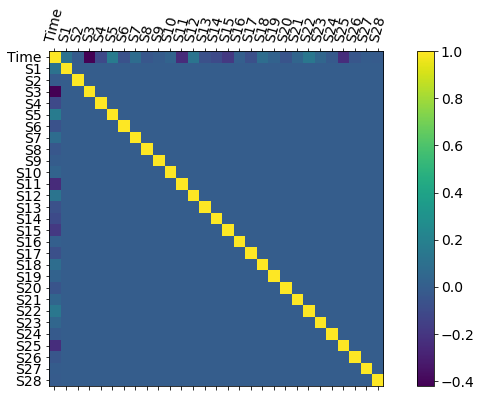

time: 825 ms (started: 2021-01-18 16:03:25 +00:00)


In [24]:
correlationMatrix = pd.DataFrame(dataX).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [25]:
#we can also simply look at the table via pandas:
correlationMatrix.style.background_gradient(cmap='viridis').set_precision(2)

,Time,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22,S23,S24,S25,S26,S27,S28
Time,1.00,0.12,-0.01,-0.42,-0.11,0.17,-0.06,0.08,-0.04,-0.01,0.03,-0.25,0.12,-0.07,-0.10,-0.18,0.01,-0.07,0.09,0.03,-0.05,0.04,0.14,0.05,-0.02,-0.23,-0.04,-0.01,-0.01
S1,0.12,1.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00
S2,-0.01,0.00,1.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00
S3,-0.42,-0.00,0.00,1.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
S4,-0.11,-0.00,-0.00,0.00,1.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00
S5,0.17,-0.00,-0.00,-0.00,-0.00,1.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00
S6,-0.06,-0.00,0.00,-0.00,0.00,-0.00,1.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00
S7,0.08,-0.00,0.00,0.00,0.00,0.00,-0.00,1.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00
S8,-0.04,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,1.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00
S9,-0.01,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,1.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00


time: 149 ms (started: 2021-01-18 16:03:26 +00:00)


*It looks like there is not a correlation in the dataset at all! Why do you think that is the case?*


**What do these numbers mean?**

When it is close to 1, it means that there is a strong positive correlation; At the other extreme; –1, it implies that there is a strong negative correlation. For more:

https://en.wikipedia.org/wiki/Correlation_and_dependence

## Preparing the Dataset for Model

We need to divide our entire dataset into fractions so that we have a training set
from which the machine learning algorithm learns. We also need another set to test the predictions of the ML algorithm. There is no golden rule here: you need to consider the size of your entire dataset. Sometimes 5% is more than enough, sometimes we need to divide 1/3 to have enough test samples. 





In [26]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.33,random_state=2018, stratify=dataY)

time: 175 ms (started: 2021-01-18 16:03:26 +00:00)


Here we have frozen the randomness to make the results reproducible. Otherwise, the results would change at every run.

Note that we will use dataY only to validate the results, not to train with the algorithm as we did in supervised machine
learning problems. 

# Evaluation Tools

## Anomaly Score

In principle, dimensionality reduction algorithms
reduce the dimensionality of data while attempting to minimize the reconstruction error; that is, the algorithm will extract pattern with the data and use them to recover its original form. If there is anomaly in the data, such as manufacturing errors, they will be the hardest to recover. We can use this idea to build up a score for anomaly detection.

We can consider it as the **approximation or reconstruction error**. 

It can be expressed as the sum of the squared differences between the original feature matrix and the reconstructed matrix using the dimensionality reduction algorithm. We will define such a function **in two steps**:

In [27]:
def anomalyScore (originalDF, reducedDF):
  #Calculating the sum of the square of residuals:
  loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
  # If you are confused about the summation axis, check the following link:
  # https://www.sharpsightlabs.com/blog/numpy-axes-explained/
  loss = pd.Series(data=loss,index=originalDF.index)
  #Normalizing the results: The idea is to mimic the labels (the best ones will be zero, the worst case will be 1)
  loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
  return loss

time: 5.63 ms (started: 2021-01-18 16:03:26 +00:00)


After obtaining the anomaly score, we can use it to construct a precision-recall curve by comparing its predictions to the labels of the dataset.

In [28]:
def plotResults(trueLabels, anomalyScore, returnPreds = False, plotting = True):
  #preparing the dataframe:
  preds = pd.concat([trueLabels, anomalyScore], axis=1)
  preds.columns = ['trueLabel', 'anomalyScore']
  
  #Calculate the precision, recall, thresholds:
  precision, recall, thresholds = \
  precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
  
  #Calculate the average precision:
  average_precision = average_precision_score(preds['trueLabel'],preds['anomalyScore'])
  if plotting:
    #Plotting the results:
    plt.step(recall, precision, color='b', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.1])
    plt.xlim([0.0, 1.0])
    plt.title('Average Precision = {0:0.2f}'.format(average_precision))

  #Do you need the preds?
  if returnPreds==True:
    return preds, average_precision

time: 10.1 ms (started: 2021-01-18 16:03:26 +00:00)


## Data Visualization

In order to see the segragation between the cases, we will use a scatter plot in 2D and 3D (after dimensionality reduction) for the visualization purposes.

In [29]:
def scatterPlot(x_DF, y_DF, methodName):
  #Filtering the first two columns (first two dimensions):
  df = pd.DataFrame(data=x_DF.loc[:,0:1], index=x_DF.index)
  #Adding the labels:
  df = pd.concat((df,y_DF), axis=1, join="inner")
  #Labeling the columns
  df.columns = ["First Dimension", "Second Dimension", "Label"]
  sns.lmplot(x="First Dimension", y="Second Dimension", hue="Label", data=df, fit_reg=False)
  ax = plt.gca()
  ax.set_title("Visualization of the data segragation using "+methodName)

time: 6.68 ms (started: 2021-01-18 16:03:26 +00:00)


In [30]:
def scatterPlot3D(x_DF, y_DF, methodName):
  #Filtering the first two columns (first three dimensions):
  df = pd.DataFrame(data=x_DF.loc[:,0:2], index=x_DF.index)
  #Adding the labels:
  df = pd.concat((df,y_DF), axis=1, join="inner")
  #Labeling the columns
  df.columns = ["First Dimension", "Second Dimension","Third Dimension", "Label"]

  # Plotting the figure:
  fig = px.scatter_3d(df, x='First Dimension', y='Second Dimension', z='Third Dimension',\
                      color='Label', symbol='Label', opacity=0.7, \
                      color_continuous_scale=px.colors.sequential.Viridis,
                      width = 600,
                      height = 500) 

  #https://plotly.com/python/reference/layout/#layout-transition
  title = "Visualization of the data segragation using "+methodName
  fig.update_layout(title_text=title, showlegend = True, hovermode = False)
  fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
  fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01))

  fig.show() 

time: 15.4 ms (started: 2021-01-18 16:03:26 +00:00)


# Autoencoders

Lets build our first autoencoder. Remember that AE consists of two sections: encoder and decoder.

Lets start simple. We will use one hidden layer as the encoder and one output layer as the decoder. We will linear activation functions for both. 

As in previous weeks, we will use Keras and TF to build up our graph. The number of nodes in this simple (E) will be equal to the number of input nodes; `X_train.shape[1]`.

In [31]:
def build_model_AE_Simple():
  #Here we will use Sequential API
  n_features, n_outputs = X_train.shape[1],X_train.shape[1] 
  model = models.Sequential([
  # define the encoder:
  layers.Dense(n_features, activation='linear', input_shape=(n_features,)),
  # define decoder:
  layers.Dense(n_outputs,activation='linear')                     
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='accuracy') 
  return model


time: 4.67 ms (started: 2021-01-18 16:03:26 +00:00)


In [32]:
#Looking at the graph:
build_model_AE_Simple().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 29)                870       
_________________________________________________________________
dense_1 (Dense)              (None, 29)                870       
Total params: 1,740
Trainable params: 1,740
Non-trainable params: 0
_________________________________________________________________
time: 825 ms (started: 2021-01-18 16:03:26 +00:00)


In [33]:
#We will first create the object to feed fit() method:
myCheckpoint= keras.callbacks.ModelCheckpoint("my_best_model_AE.h5", save_best_only=True)

time: 1.99 ms (started: 2021-01-18 16:03:27 +00:00)


In [34]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

time: 1.61 ms (started: 2021-01-18 16:03:27 +00:00)


## Model Training

I would advise to look FAQ section of Keras (TF) if you encounter an issue during the training.

https://keras.io/getting_started/faq/

Here one distinct difference that **we will not use labels during the training. ** In AE, we will reconstruct the X matrix, hence the goal of the output layer is the X matrix, not the y values. Here I will pass the training data as the validation set as well to see how it will perform.

In [35]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 128

time: 1.47 ms (started: 2021-01-18 16:03:27 +00:00)


In [36]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_base = build_model_AE_Simple()

#Training step: Trains the model in silent mode (verbose = 0)
history_base = model_base.fit(X_train, X_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_train, X_train) , 
                                callbacks=[myCheckpoint,myEarly_stopping])#, verbose=0)
#Calling back the best model:
model_best = keras.models.load_model("my_best_model_AE.h5")


Epoch 1/100
1491/1491 [==============================] - 6s 4ms/step - loss: 0.6089 - accuracy: 0.4792 - val_loss: 0.0048 - val_accuracy: 0.9562
Epoch 2/100
1491/1491 [==============================] - 5s 3ms/step - loss: 0.0011 - accuracy: 0.9842 - val_loss: 3.5538e-10 - val_accuracy: 1.0000
Epoch 3/100
1491/1491 [==============================] - 5s 3ms/step - loss: 6.0062e-11 - accuracy: 1.0000 - val_loss: 8.5619e-13 - val_accuracy: 1.0000
Epoch 4/100
1491/1491 [==============================] - 5s 3ms/step - loss: 1.8505e-13 - accuracy: 1.0000 - val_loss: 3.1839e-14 - val_accuracy: 1.0000
Epoch 5/100
1491/1491 [==============================] - 5s 3ms/step - loss: 6.5567e-07 - accuracy: 0.9999 - val_loss: 0.0014 - val_accuracy: 0.9837
Epoch 6/100
1491/1491 [==============================] - 5s 3ms/step - loss: 4.7464e-04 - accuracy: 0.9942 - val_loss: 2.5730e-05 - val_accuracy: 0.9967
Epoch 7/100
1491/1491 [==============================] - 5s 3ms/step - loss: 1.0973e-05 - accuracy

In [37]:
#Lets look into the history recorded:
hist = pd.DataFrame(history_base.history)

time: 2.6 ms (started: 2021-01-18 16:05:11 +00:00)


In [38]:
#Adding epoch column:
hist['epoch'] = history_base.epoch

time: 1.96 ms (started: 2021-01-18 16:05:11 +00:00)


In [39]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history['epoch'],history['loss'], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'],history['val_loss'], "b-.", linewidth=1.5, label="Validation")
  plt.legend()
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Loss (MSE)")

time: 3.78 ms (started: 2021-01-18 16:05:11 +00:00)


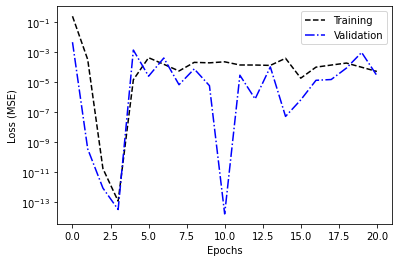

time: 358 ms (started: 2021-01-18 16:05:11 +00:00)


In [40]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist)

In [41]:
#Making predictions:
X_test_predictions = pd.DataFrame(model_best.predict(X_test),index=X_test.index)

time: 1.83 s (started: 2021-01-18 16:05:11 +00:00)


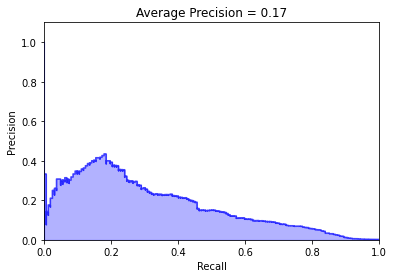

time: 319 ms (started: 2021-01-18 16:05:13 +00:00)


In [42]:
#Using our own evaluation score for anomaly detection:
anomalyScoresAE = anomalyScore(X_test,X_test_predictions)
preds = plotResults(y_test, anomalyScoresAE,False, True)

## Model Stability

Lets train the model couple of times to see the stability of our predictions. We will build a for loop for that purpose, while keeping the average precision as a performance criteria. 

In [ ]:
#Hyperparameters:
num_epochs = 10
batch_size = 32
#Listing test scores
test_scores = []
#We will train the model 5 times and see how performance fluctuates...
for i in range(0,5):
  #Building the Keras models:
  model_base = build_model_AE_Simple()

  #Training step: Trains the model in silent mode (verbose = 0)
  history_loop = model_base.fit(X_train, X_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_train, X_train),
                                verbose=0)

  #Model evaluation:
  X_test_predictions = pd.DataFrame(model_base.predict(X_test),index=X_test.index)
  anomalyScoresAE = anomalyScore(X_test,X_test_predictions)
  preds, meanPrecision = plotResults(y_test, anomalyScoresAE,True, False)
  test_scores.append(meanPrecision)
  print('In progress: ',i,'/4 ...')


In progress:  0 /4 ...


In [ ]:
test_scores

In [ ]:
#Lets see how stable our model is:
print('The mean score is ',np.mean(test_scores) ,'with SD of ', np.std(test_scores))

**Why did AE fail this much?**

In this simple example, we used a **complete** AE, where the NN simple memorizes to reproduce input as the output. Therefore, it is expected to fail for cases it has never seen before. Lets do better this time!


# Undercomplete - AE: four layers
 
 This time, lets use the same number of layers but with less computational nodes; so that the AE is forced to extract some patterns from the data.

 Note that if you don't specify anything for the activation function, no activation is applied (ie. "linear" activation: a(x) = x). Here it is written just to remind us what is being done.

In [ ]:
def build_model_AE_Simple_2():
  #Here we will use Sequential API
  n_features, n_outputs = X_train.shape[1],X_train.shape[1] 
  model = models.Sequential([
  # define the encoder with decreasing # of nodes
  layers.Dense(25, activation='linear', input_shape=(n_features,)),
  layers.Dense(20,activation='linear'),
  layers.Dense(15,activation='linear'),
  # define decoder:
  layers.Dense(20,activation='linear'),
  layers.Dense(25,activation='linear'),
  layers.Dense(n_outputs)                     
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='accuracy') 
  return model


In [ ]:
#Looking at the graph:
build_model_AE_Simple_2().summary()

In [ ]:
#We will first create the object to feed fit() method:
myCheckpoint_2= keras.callbacks.ModelCheckpoint("my_best_model_AE_2.h5", save_best_only=True)

In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping_2 = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

## Model Training

In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 128

In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_base = build_model_AE_Simple_2()

#Training step: Trains the model in silent mode (verbose = 0)
history_base_2 = model_base.fit(X_train, X_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_train, X_train) , 
                                callbacks=[myCheckpoint_2,myEarly_stopping_2])#, verbose=0)
#Calling back the best model:
model_best_2 = keras.models.load_model("my_best_model_AE_2.h5")


In [ ]:
#Making predictions:
X_test_predictions = pd.DataFrame(model_best_2.predict(X_test),index=X_test.index)

In [ ]:
#Using our own evaluation score for anomaly detection:
anomalyScoresAE = anomalyScore(X_test,X_test_predictions)
preds = plotResults(y_test, anomalyScoresAE,False, True)

## Model Stability

In [ ]:
#Hyperparameters:
num_epochs = 10
batch_size = 32
#Listing test scores
test_scores = []
#We will train the model 6 times and see how performance fluctuates...
for i in range(0,6):
  #Building the Keras models:
  model_base = build_model_AE_Simple_2()

  #Training step: Trains the model in silent mode (verbose = 0)
  history_loop = model_base.fit(X_train, X_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_train, X_train), verbose=0)

  #Model evaluation:
  X_test_predictions = pd.DataFrame(model_base.predict(X_test),index=X_test.index)
  anomalyScoresAE = anomalyScore(X_test,X_test_predictions)
  preds, meanPrecision = plotResults(y_test, anomalyScoresAE,True, False)
  test_scores.append(meanPrecision)
  print('In progress: ',i,'/6 ...')

In [ ]:
test_scores

In [ ]:
#Lets see how stable our model is:
print('The mean score is ',np.mean(test_scores) ,'with SD of ', np.std(test_scores))

# Nonlinear AE: Using different activation functions

One option here is to use alternative activation functions to extract nonlinear patterns in the data. From our previous experience on the dataset, we know that linear models seems to be better here (as the X shows little correlations between features). Nevertheless, lets see how it can be implemented. 

In [ ]:
def build_model_AE_reLU():
  #Here we will use Sequential API
  n_features, n_outputs = X_train.shape[1],X_train.shape[1] 
  model = models.Sequential([
  # define the encoder:
  layers.Dense(25, kernel_initializer="he_normal", input_shape=(n_features,)),keras.layers.LeakyReLU(alpha=0.1),                           
  layers.BatchNormalization(),
  layers.Dense(20, kernel_initializer="he_normal"),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(15, kernel_initializer="he_normal"),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  # define decoder:
  layers.Dense(20, kernel_initializer="he_normal"),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(25, kernel_initializer="he_normal"),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(n_outputs, kernel_initializer="he_normal"),keras.layers.LeakyReLU(alpha=0.1),                  
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='accuracy') 
  return model


In [ ]:
#Looking at the graph:
build_model_AE_reLU().summary()

In [ ]:
#We will first create the object to feed fit() method:
myCheckpoint_reLU= keras.callbacks.ModelCheckpoint("my_best_model_AE_reLU.h5", save_best_only=True)

In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping_reLU = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

## Model Training 

In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 128

In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_reLU = build_model_AE_reLU()

#Training step: Trains the model in silent mode (verbose = 0)
history_reLU = model_reLU.fit(X_train, X_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_train, X_train) , 
                                callbacks=[myCheckpoint_reLU,myEarly_stopping_reLU])#, verbose=0)
#Calling back the best model:
model_best_reLU = keras.models.load_model("my_best_model_AE_reLU.h5")


In [ ]:
#Making predictions:
X_test_predictions = pd.DataFrame(model_best_reLU.predict(X_test),index=X_test.index)

In [ ]:
#Using our own evaluation score for anomaly detection:
anomalyScoresAE = anomalyScore(X_test,X_test_predictions)
preds = plotResults(y_test, anomalyScoresAE,False, True)

# Sparse AE: Simple Tools

One way to enforce sparse, overcomplete AE is to use readily available simple tricks:

+ l1 regularization
+ sigmoid activation functions

For that purpose, we first need to go into higher dimensions in the first dense layer; then decrease the number of dimensions. 

In [ ]:
def build_model_AE_Sparse():
  #Here we will use Sequential API
  n_features, n_outputs = X_train.shape[1],X_train.shape[1] 
  model = models.Sequential([
  # define the encoder with decreasing # of nodes
  layers.Dense(60, kernel_initializer="he_normal", input_shape=(n_features,)),keras.layers.LeakyReLU(alpha=0.1),                           
  layers.BatchNormalization(),
  layers.Dense(120,activation='sigmoid', activity_regularizer=keras.regularizers.l1(1e-5)),
  layers.BatchNormalization(),
  layers.Dense(180,activation='sigmoid', activity_regularizer=keras.regularizers.l1(1e-5)),
  layers.BatchNormalization(),
  # define decoder:
  layers.Dense(120,activation='sigmoid', activity_regularizer=keras.regularizers.l1(1e-5)),
  layers.BatchNormalization(),
  layers.Dense(60,activation='sigmoid', activity_regularizer=keras.regularizers.l1(1e-5)),
  layers.BatchNormalization(),
  layers.Dense(n_outputs)                     
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='accuracy') 
  return model


In [ ]:
#Looking at the graph:
build_model_AE_Sparse().summary()

In [ ]:
#We will first create the object to feed fit() method:
myCheckpoint_Sparse= keras.callbacks.ModelCheckpoint("my_best_model_AE_Sparse.h5", save_best_only=True)

In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping_Sparse = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

## Model Training 

In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 128

In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_Sparse = build_model_AE_Sparse()

#Training step: Trains the model in silent mode (verbose = 0)
history_Sparse = model_Sparse.fit(X_train, X_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_train, X_train) , 
                                callbacks=[myCheckpoint_Sparse,myEarly_stopping_Sparse])#, verbose=0)
#Calling back the best model:
model_best_Sparse = keras.models.load_model("my_best_model_AE_Sparse.h5")


In [ ]:
#Lets look into the history recorded:
hist = pd.DataFrame(history_Sparse.history)

In [ ]:
#Adding epoch column:
hist['epoch'] = history_Sparse.epoch

In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history['epoch'],history['loss'], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'],history['val_loss'], "b-.", linewidth=1.5, label="Validation")
  plt.legend()
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Loss (MSE)")

In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist)

In [ ]:
#Making predictions:
X_test_predictions = pd.DataFrame(model_best_Sparse.predict(X_test),index=X_test.index)

In [ ]:
#Using our own evaluation score for anomaly detection:
anomalyScoresAE = anomalyScore(X_test,X_test_predictions)
preds = plotResults(y_test, anomalyScoresAE,False, True)

# Sparse AE: Alternative Approach

It is also possible to monitor the sparsity of the network. We can manipulate the network by penalizing the neurons that are either over-active, or under-active via enforcing a sparsity loss.

For that purpose, we need to add a custom regularizer function by using KL divergence. It is an important concept in ML. Here I leave some references to explore:

https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

https://machinelearningmastery.com/divergence-between-probability-distributions/

https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8

https://dibyaghosh.com/blog/probability/kldivergence.html

https://www.sciencedirect.com/science/article/pii/S1877050918317939

https://medium.com/@syoya/what-happens-in-sparse-autencoder-b9a5a69da5c6

If you want learn more about the implementation:

https://keras.io/api/layers/regularizers/

https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer

https://www.tensorflow.org/probability/api_docs/python/tfp/layers/KLDivergenceRegularizer

https://ieeexplore.ieee.org/document/7280364

https://web.stanford.edu/class/cs294a/sparseAutoencoder.pdf

In [ ]:
#We will impose the additional cost on activity regularizer 
# to apply a penalty on the layer's output (like l1 in previous section).
# Developing new regularizer described here with an example:
#https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
#
#Lets do it for kl_divergence:
#https://keras.io/api/utils/backend_utils/
K = keras.backend
#Calling the additional cost fucntion:
kl_divergence = keras.losses.kullback_leibler_divergence
#
class KLDivergenceRegularizer(keras.regularizers.Regularizer):
  def __init__(self, weight, target=0.1):
    self.weight = weight
    self.target = target
  def get_config(self):
    return {'weight': float(self.weight), 'target':float(self.target)}
  def __call__(self, inputs):
    mean_activities = K.mean(inputs, axis=0)
    return self.weight *(kl_divergence(self.target, mean_activities) + kl_divergence(1. - self.target, 1. - mean_activities))

In [ ]:
def build_model_AE_Sparse_2():
  #Here we will use Sequential API
  n_features, n_outputs = X_train.shape[1],X_train.shape[1] 
  #Here we will define its impact as well as the target sparsity:
  kld_reg = KLDivergenceRegularizer(weight=0.03, target=0.1)
  model = models.Sequential([
  # define the encoder with decreasing # of nodes
  layers.Dense(60, kernel_initializer="he_normal", input_shape=(n_features,)),keras.layers.LeakyReLU(alpha=0.1),                           
  layers.BatchNormalization(),
  layers.Dense(120,kernel_initializer="he_normal", activity_regularizer=kld_reg),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(180,kernel_initializer="he_normal", activity_regularizer=kld_reg),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  # define decoder:
  layers.Dense(120,kernel_initializer="he_normal", activity_regularizer=kld_reg),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(60,kernel_initializer="he_normal", activity_regularizer=kld_reg),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(n_outputs)                     
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='accuracy') 
  return model


In [ ]:
#Looking at the graph:
build_model_AE_Sparse_2().summary()

In [ ]:
#We will first create the object to feed fit() method:
myCheckpoint_Sparse_2= keras.callbacks.ModelCheckpoint("my_best_model_AE_Sparse_2.h5", save_best_only=True)

In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping_Sparse_2 = keras.callbacks.EarlyStopping(patience=25,restore_best_weights=True)

## Model Training 

In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 128

In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_Sparse_2 = build_model_AE_Sparse_2()

#Training step: Trains the model in silent mode (verbose = 0)
history_Sparse_2 = model_Sparse_2.fit(X_train, X_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_train, X_train) , 
                                callbacks=[myCheckpoint_Sparse_2,myEarly_stopping_Sparse_2])#, verbose=0)



In [ ]:
#Calling back the best model:
#here you need to inform TF about your custom object (https://github.com/keras-team/keras/issues/9377)
model_best_Sparse_2 = keras.models.load_model("my_best_model_AE_Sparse_2.h5",custom_objects={'KLDivergenceRegularizer': KLDivergenceRegularizer})

In [ ]:
#Lets look into the history recorded:
hist = pd.DataFrame(history_Sparse_2.history)

In [ ]:
#Adding epoch column:
hist['epoch'] = history_Sparse_2.epoch
hist.head(1)

In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history['epoch'],history['loss'], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'],history['val_loss'], "b-.", linewidth=1.5, label="Validation")
  plt.legend()
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Loss (MSE)")

In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist)

In [ ]:
#Making predictions:
X_test_predictions = pd.DataFrame(model_best_Sparse_2.predict(X_test),index=X_test.index)

In [ ]:
#Using our own evaluation score for anomaly detection:
anomalyScoresAE = anomalyScore(X_test,X_test_predictions)
preds = plotResults(y_test, anomalyScoresAE,False, True)

# De-noising the data with AEs

Another use case for AEs is the elimination of noise in the input matrix X. This could be due to the measurement setup, the sensory device itself or some numerical dissipation. 

Lets see how it works. Here I will add additional noise in the data to mimick the possible noises I would expect. Note that **here we assume you have some less noisy data for training.**

In [ ]:
#Adding artificial noise to X:
noise_factor = 0.10
X_train_noisy = X_train.copy() + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test.copy() + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

In [ ]:
def build_model_AE_noise():
  #Here we will use Sequential API
  n_features, n_outputs = X_train_noisy.shape[1],X_train_noisy.shape[1] 
  model = models.Sequential([
  # define the encoder with decreasing # of nodes
  layers.Dense(25, activation='linear', input_shape=(n_features,)),
  layers.Dense(20,activation='linear'),
  layers.Dense(15,activation='linear'),
  # define decoder:
  layers.Dense(20,activation='linear'),
  layers.Dense(25,activation='linear'),
  layers.Dense(n_outputs)                     
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='accuracy') 
  return model


In [ ]:
#Looking at the graph:
build_model_AE_noise().summary()

In [ ]:
#We will first create the object to feed fit() method:
myCheckpoint_noise= keras.callbacks.ModelCheckpoint("my_best_model_noise.h5", save_best_only=True)

In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping_noise = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

## Model Training

In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 128

In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_noise = build_model_AE_noise()

#Training step: Trains the model in silent mode (verbose = 0)
history_base_noise = model_noise.fit(X_train_noisy, X_train_noisy, epochs=num_epochs, batch_size=batch_size, validation_data=(X_train_noisy, X_train_noisy) , 
                                callbacks=[myCheckpoint_noise,myEarly_stopping_noise])#, verbose=0)
#Calling back the best model:
model_best_noise = keras.models.load_model("my_best_model_noise.h5")


In [ ]:
#Making predictions:
X_test_predictions = pd.DataFrame(model_best_noise.predict(X_test_noisy),index=X_test_noisy.index)

In [ ]:
#Using our own evaluation score for anomaly detection:
anomalyScoresAE = anomalyScore(X_test_noisy,X_test_predictions)
preds = plotResults(y_test, anomalyScoresAE,False, True)

In general, it usually perfoms better when nonlinear activation functions are used for denoising. You may experiment yourself whether that will also be the case in this outlier detection problem. 

# AEs as an Interpolator 

A similar trick is used to process input data that is partially missing. In the architecture, it is mimicked as a dropout layer at the first layer. 

In [ ]:
def build_model_int():
  #Here we will use Sequential API
  n_features, n_outputs = X_train.shape[1],X_train.shape[1] 
  #Here we will define its impact as well as the target sparsity:
  kld_reg = KLDivergenceRegularizer(weight=0.03, target=0.1)
  model = models.Sequential([
  # define the encoder with decreasing # of nodes
  layers.Dense(60, kernel_initializer="he_normal", input_shape=(n_features,)),keras.layers.LeakyReLU(alpha=0.1),                           
  layers.Dropout(0.20),
  layers.BatchNormalization(),
  layers.Dense(120,kernel_initializer="he_normal", activity_regularizer=kld_reg),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(180,kernel_initializer="he_normal", activity_regularizer=kld_reg),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  # define decoder:
  layers.Dense(120,kernel_initializer="he_normal", activity_regularizer=kld_reg),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(60,kernel_initializer="he_normal", activity_regularizer=kld_reg),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(n_outputs)                     
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='accuracy') 
  return model


In [ ]:
#Looking at the graph:
build_model_int().summary()

In [ ]:
#We will first create the object to feed fit() method:
myCheckpoint_int= keras.callbacks.ModelCheckpoint("my_best_model_AE_int.h5", save_best_only=True)

In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping_int = keras.callbacks.EarlyStopping(patience=25,restore_best_weights=True)

## Model Training

In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 128

In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_int = build_model_int()

#Training step: Trains the model in silent mode (verbose = 0)
history_int = model_int.fit(X_train, X_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_train, X_train) , 
                                callbacks=[myCheckpoint_int,myEarly_stopping_int])#, verbose=0)



In [ ]:
#Calling back the best model:
#here you need to inform TF about your custom object (https://github.com/keras-team/keras/issues/9377)
model_best_int = keras.models.load_model("my_best_model_AE_int.h5",custom_objects={'KLDivergenceRegularizer': KLDivergenceRegularizer})

In [ ]:
#Making predictions:
X_test_predictions = pd.DataFrame(model_best_int.predict(X_test),index=X_test.index)

In [ ]:
#Using our own evaluation score for anomaly detection:
anomalyScoresAE = anomalyScore(X_test,X_test_predictions)
preds = plotResults(y_test, anomalyScoresAE,False, True)

# Transfer Learning with AEs

It is a common practice now to use latent space variables in a second ML / probabilistic based models to exploit sparse, reduced order representations of dynamical systems. One recent example is the integration of SINDy with Autoencoders:

https://www.youtube.com/watch?v=WHhDgxkiR9c

Here you can do one-way coupling or two-way coupling. 

In the one-way version, we do a sequential analysis. The idea is simple: you train the AE to generate the latent space variables. Then, you pass this information to a second model having a different task like regression, classification etc. 

In two-way coupling, you train your AE together with the second model by enforcing a joint error function so that you look for the optimum solution in a coupled way. 

In this exercise, we will see how we can pass weights to another network in TF. We will explore dynamical systems in more depth during DDE-2. 

You may also see below link for Keras implementation:

https://keras.io/guides/transfer_learning/

In [ ]:
# Copying the base model:
base_model_x = keras.models.load_model("my_best_model_AE_int.h5",custom_objects={'KLDivergenceRegularizer': KLDivergenceRegularizer})

In [ ]:
#Lets see the layers:
base_model_x.summary()

Lets say that we are interested in passing the weights of the encoders. In this case, we can cut the pretrained NN at the desired location:

In [ ]:
model_new = Sequential()
for layer in base_model_x.layers[:10]: # get the encoder
    model_new.add(layer)
#Here I will freeze the weights so that they will not be changed during the training:
for layer in model_new.layers[:]:
  layer.trainable = False
#Say we will add a dense layer for classification:
model_new.add(Dense(3, activation='softmax'))
#Lets see:
model_new.summary()

Here you can see that only trainable parameters are from the last layer.

You can also call specific layer weights and copy them on a new NN. If you give names to each layer, you can also use these names during the data transfer. 

In [ ]:
#For descriptions:
#https://keras.io/api/layers/base_layer/#set_weights-method
#https://keras.io/api/layers/base_layer/#get_weights-method
weights_passing = base_model_x.layers[6].get_weights()
model_new.layers[6].set_weights(weights_passing)

In [ ]:
#Model is compiled similarly:
model_new.compile(optimizer='adam', loss='categorical_crossentropy')

# Reading Material

https://scikit-learn.org/stable/modules/decomposition.html

https://ocw.mit.edu/courses/mathematics/18-650-statistics-for-applications-fall-2016/lecture-slides/MIT18_650F16_PCA.pdf

https://www.knime.com/blog/seven-techniques-for-data-dimensionality-reduction

http://cs229.stanford.edu/notes2020spring/cs229-notes10.pdf


